In [1]:
import warnings
import pandas as pd
import numpy as np
import pandas as pd
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import datetime
import pickle
import math
from tslearn.clustering import TimeSeriesKMeans
from tslearn.barycenters import dtw_barycenter_averaging

sns.set(color_codes=True, font_scale=1.5)


/home/juan/miniconda3/envs/tfm/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


### Load and create datetime index

In [4]:
%run -i '../preprocessing.py'

### Time series cycle clustering

In [5]:
start_day = '2022-01-21 00:00:00'
end_day = '2022-02-20 23:58:00'

start_day = pd.to_datetime(start_day, format='%Y-%m-%d %H:%M:%S')
end_day = pd.to_datetime(end_day, format='%Y-%m-%d %H:%M:%S')

normal_df = dfCV1[dfCV1.index.to_series().between(start_day, end_day)]


In [6]:
len(normal_df)

22320

In [7]:
ref_speed = normal_df['XXXXXXXXXXXX']
rupture_idx = 0
rupture_list = list()
list_500 = pd.DataFrame(np.where(ref_speed <= 500)).T.groupby(by=[0]).count().index.tolist()


In [8]:
for idx in list_500:
    if rupture_idx == idx-1:
        rupture_idx += 1
    else:
        rupture_list.append(rupture_idx)
        rupture_list.append(idx)
        rupture_idx = idx
rupture_list.append(idx)
rupture_list.remove(0)
len(rupture_list)//2

744

In [9]:
np.mean([rupture_list[i+2] - rupture_list[i+1] for i in range(0, len(rupture_list)-2, 2)])

24.989232839838493

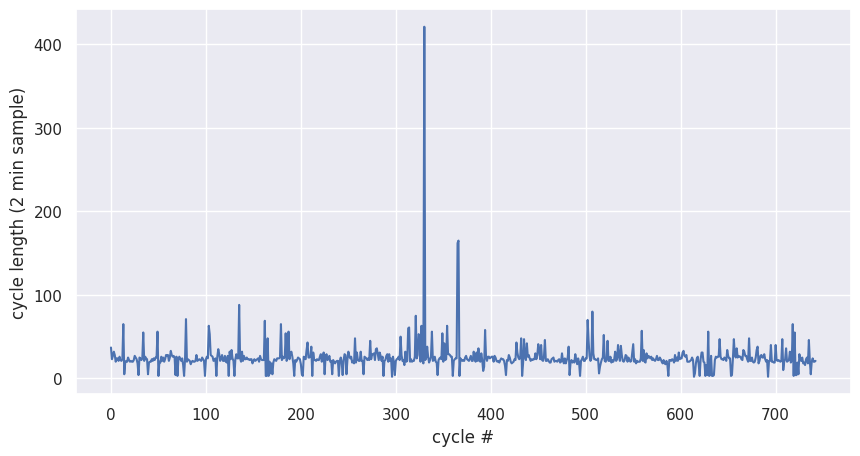

In [20]:
sns.set(font_scale=1)

plt.figure(figsize=(10,5))
plt.plot([rupture_list[i+2] - rupture_list[i+1] for i in range(0, len(rupture_list)-2, 2)])
plt.xlabel('cycle #')
plt.ylabel('cycle length (2 min sample)')

sns.set(font_scale=1.5)


In [ ]:
for i in range(0, len(rupture_list)-1, 2)[:50]:
    normal_df.iloc[rupture_list[i+1]:rupture_list[i+2]+1]['XXXXXXXXXXXX'].plot()
    plt.show()
    break

    

In [12]:
cycle_df = pd.DataFrame()
for i in range(0, len(rupture_list)-2, 2):    
    cycle_df = pd.concat([cycle_df,pd.DataFrame(normal_df[rupture_list[i+1]:rupture_list[i+2]+1]['XXXXXXXXXX'].values, columns=[f'{i//2}'])], axis=1)

In [ ]:
odd_idx = np.argsort([rupture_list[i+2] - rupture_list[i+1] for i in range(0, len(rupture_list)-2, 2)])[::-1]
plt.plot(cycle_df.iloc[:, odd_idx[2]])

In [14]:
cycle_df = cycle_df.drop(cycle_df.columns[odd_idx[:3]], axis=1)

In [15]:
cluster_count = 4
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw", n_jobs=-1, max_iter=100, n_init=4, random_state=42)
labels = km.fit_predict(cycle_df.T)

In [ ]:
plot_count = math.ceil(math.sqrt(cluster_count))
som_x = som_y = 2
fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(cycle_df[cycle_df.columns[i]],c="gray",alpha=0.08)
                cluster.append(cycle_df[cycle_df.columns[i]])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(dtw_barycenter_averaging(np.vstack(cluster)),c="#440053")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()


In [17]:
np.unique(np.array(labels), return_counts=True)
labels = labels.tolist()

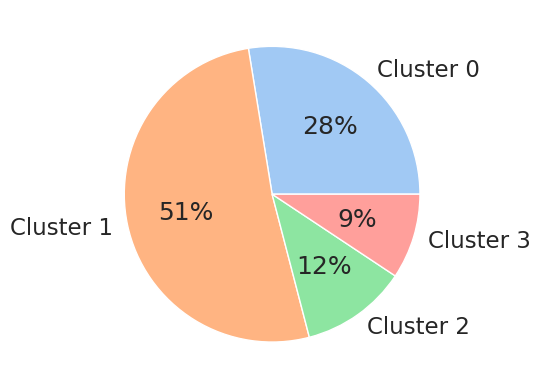

In [18]:
data = [204, 381,  86,  69]
pielabels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:4]

#create pie chart
plt.pie(data, labels = pielabels, colors = colors, autopct='%.0f%%')
plt.show()

In [ ]:
# sns.set(font_scale=1)
for i in range(0, len(labels)-1)[122:123]:
    if labels[i] == 1:
        normal_df[rupture_list[int(cycle_df.columns[i])*2]:rupture_list[int(cycle_df.columns[i])*2+2]+3]['XXXXXXXXXXXX'].reset_index(drop=True).plot()
        plt.xlabel('duration (2 min sample)')
        plt.ylabel('RPM')
        plt.title('Speed conditions in a normal cycle')
        
        plt.axvspan(0, 5, facecolor='purple', alpha=0.2)
        plt.axvspan(34, 36, facecolor='purple', alpha=0.2)
        plt.axvspan(5, 7, facecolor='b', alpha=0.3)
        plt.axvspan(10, 12, facecolor='b', alpha=0.3)
        plt.axvspan(17, 25, facecolor='b', alpha=0.3)
        plt.axvspan(7, 10, facecolor='b', alpha=0.75)
        plt.axvspan(12, 17, facecolor='b', alpha=0.5)
        plt.axvspan(25, 31, facecolor='orange', alpha=0.2)
        plt.axvspan(31, 34, facecolor='lime', alpha=0.2)

        legend_handles = [
            Patch(facecolor='purple', alpha=0.3, label='Idle'),
            Patch(facecolor='b', alpha=0.2, label='Blow RSW < 50%'),
            Patch(facecolor='b', alpha=0.5, label='Blow RSW 50% - 70%'),
            Patch(facecolor='b', alpha=0.75, label='Blow RSW > 70%'),
            Patch(facecolor='orange', alpha=0.2, label='Tapping'),
            Patch(facecolor='lime', alpha=0.2, label='Splash')
        ]

        # Add the legend to the plot
        plt.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.savefig('figures/cycle_parts.svg', format='svg', bbox_inches = 'tight')
        plt.show()


In [23]:
change = True
while change:
    delcols = list()
    dellabels = list()
    change = False
    for i in range(0, len(labels)-1):
        if (labels[i] == 0) and labels[i+1] == 3 and (~cycle_df[cycle_df.columns[i+1]].isna()).sum() < 10:
            cycle_df[cycle_df.columns[i]] = pd.Series(pd.concat([cycle_df.loc[~cycle_df[cycle_df.columns[i]].isna(), cycle_df.columns[i]], cycle_df.loc[~cycle_df[cycle_df.columns[i+1]].isna(), cycle_df.columns[i+1]]], axis=0).values)
            delcols.append(cycle_df.columns[i+1])
            dellabels.append(i+1)
            change = True

            
        if (labels[i] == 1) and labels[i+1] == 3 and (~cycle_df[cycle_df.columns[i+1]].isna()).sum() < 10:
            cycle_df[cycle_df.columns[i]] = pd.Series(pd.concat([cycle_df.loc[~cycle_df[cycle_df.columns[i]].isna(), cycle_df.columns[i]], cycle_df.loc[~cycle_df[cycle_df.columns[i+1]].isna(), cycle_df.columns[i+1]]], axis=0).values)
            delcols.append(cycle_df.columns[i+1])
            dellabels.append(i+1)
            change = True

            
        if (labels[i] == 2) and labels[i+1] == 3 and (~cycle_df[cycle_df.columns[i+1]].isna()).sum() < 10:
            cycle_df[cycle_df.columns[i]] = pd.Series(pd.concat([cycle_df.loc[~cycle_df[cycle_df.columns[i]].isna(), cycle_df.columns[i]], cycle_df.loc[~cycle_df[cycle_df.columns[i+1]].isna(), cycle_df.columns[i+1]]], axis=0).values)
            delcols.append(cycle_df.columns[i+1])
            dellabels.append(i+1)
            change = True


        if (labels[i] == 3) and labels[i+1] == 3 and (~cycle_df[cycle_df.columns[i+1]].isna()).sum() < 10 and cycle_df.columns[i] not in delcols:
            cycle_df[cycle_df.columns[i]] = pd.Series(pd.concat([cycle_df.loc[~cycle_df[cycle_df.columns[i]].isna(), cycle_df.columns[i]], cycle_df.loc[~cycle_df[cycle_df.columns[i+1]].isna(), cycle_df.columns[i+1]]], axis=0).values)
            delcols.append(cycle_df.columns[i+1])
            dellabels.append(i+1)
            change = True
    
    for index in sorted(dellabels, reverse=True):
        del labels[index]

    cycle_df = cycle_df.drop(columns=delcols)

        


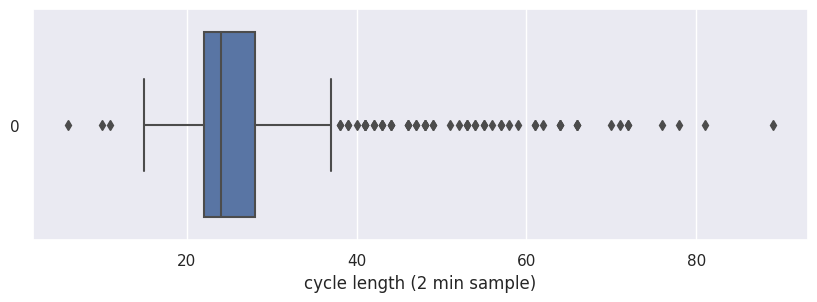

In [24]:
sns.set(font_scale=1)
plt.figure(figsize=(10,3))
sns.boxplot([(~cycle_df[cycle_df.columns[i]].isna()).sum() for i in range(0, len(cycle_df.columns))], orient="h")
plt.xlabel('cycle length (2 min sample)')

sns.set(font_scale=1.5)


In [25]:
np.mean([(~cycle_df[cycle_df.columns[i]].isna()).sum() for i in range(0, len(cycle_df.columns))])

27.093430656934306

In [26]:
cluster_count = 3
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw", n_jobs=-1, max_iter=100, n_init=6, random_state=2)
labels = km.fit_predict(cycle_df.T)


In [ ]:
plot_count = math.ceil(math.sqrt(cluster_count))
som_x = som_y = 2
fig, axs = plt.subplots(1,3,figsize=(40,13))
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[column_j].plot(cycle_df[cycle_df.columns[i]],c="gray",alpha=0.08)
                cluster.append(cycle_df[cycle_df.columns[i]])
    if len(cluster) > 0:
        axs[column_j].plot(dtw_barycenter_averaging(np.vstack(cluster)),c="#440053")
    axs[column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
plt.savefig('figures/kmeans.eps', format='eps')
plt.show()


In [28]:
np.unique(np.array(labels), return_counts=True)

(array([0, 1, 2]), array([199, 360, 126]))

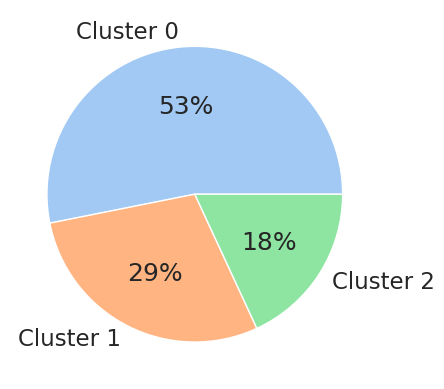

In [29]:
data = [364, 197, 124]
pielabels = ['Cluster 0', 'Cluster 1', 'Cluster 2']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:4]

#create pie chart
plt.pie(data, labels = pielabels, colors = colors, autopct='%.0f%%')
plt.show()

In [31]:
# sns.set(font_scale=1)
# for i in range(0, len(labels)-1):
#     if labels[i] == 0 and labels[i+1] == 0:
#         continue
#         normal_df[rupture_list[int(cycle_df.columns[i])*2]-1:rupture_list[int(cycle_df.columns[i])*2+2]+20]['CV1.LD_SIC22833_CV'].plot()
#         plt.show()
#         break
#     if (~cycle_df[cycle_df.columns[i]].isna()).sum() < 20:
#         normal_df[rupture_list[int(cycle_df.columns[i])*2]:rupture_list[int(cycle_df.columns[i])*2+2]+5]['CV1.LD_SIC22833_CV'].plot()

#         plt.show()
#         print(labels[i])

# sns.set(font_scale=1.5)


In [33]:
# for i in range(0, len(labels))[200:250]:
#     if labels[i] == 0:
#         cycle_df[cycle_df.columns[i]].plot()
#         plt.show()
    

# Build new dataset

In [39]:
# cycle_datetimes = dict()
# for i in range(0, len(labels)):
#     if i == len(labels)-1:
#         cycle_datetimes[f'c{i}'] = [normal_df.index[rupture_list[int(cycle_df.columns[i])*2]-1], normal_df.index[rupture_list[int(cycle_df.columns[i])*2+2]]]
#     else:
#         cycle_datetimes[f'c{i}'] = [normal_df.index[rupture_list[int(cycle_df.columns[i])*2]-1], normal_df.index[rupture_list[int(cycle_df.columns[i])*2+2]+1]]

In [42]:
# +1/+2 whether or not to save the idle time

cycle_datetimes = dict()
for i in range(0, len(labels)):
    if i == len(labels)-1:
        cycle_datetimes[f'c{i}'] = [normal_df.index[rupture_list[int(cycle_df.columns[i])*2+1]-1], normal_df.index[rupture_list[int(cycle_df.columns[i])*2+2]]]
    else:
        cycle_datetimes[f'c{i}'] = [normal_df.index[rupture_list[int(cycle_df.columns[i])*2+1]-1], normal_df.index[rupture_list[int(cycle_df.columns[i])*2+2]+1]]

In [41]:
# with open('cycle_datetimes', 'wb') as cdts:
#     pickle.dump(cycle_datetimes, cdts)

In [34]:
with open('cycle_datetimes', 'rb') as cdts:
    cycle_datetimes = pickle.load(cdts)

In [35]:
new_normal_df = pd.DataFrame()
chunkie_list = []
for i in range(0, len(cycle_datetimes.keys())):
    start_day, end_day = cycle_datetimes[f'c{i}']
    normal_slice = normal_df[normal_df.index.to_series().between(start_day, end_day)]
    normal_slice.columns = [f'c{i}_' + colname for colname in normal_slice.columns]
    normal_slice = normal_slice.reset_index(drop=True)
    chunkie_list.append(normal_slice)
new_normal_df = pd.concat(chunkie_list, axis=1)
del chunkie_list

# new_normal_df.to_csv('cycle_dataset.csv', index=False)
    

In [36]:
len(new_normal_df.columns)//31

773

In [38]:
def plot_sequences(ids:list[str], data_set: pd.DataFrame, start_day:datetime.datetime, end_day:datetime.datetime):
    from plotly.subplots import make_subplots
    import plotly.graph_objects as go

    num_plots = len(ids)
    fig = make_subplots(rows=num_plots, cols=1, subplot_titles=[translation_dict[id] for id in ids])
    # fig = make_subplots(rows=num_plots, cols=1, subplot_titles=ids)

    data_set = data_set[data_set.index.to_series().between(start_day, end_day)]
    for i, seq_id in enumerate(ids):
        fig.append_trace(go.Scatter(
            mode='lines',
            x=data_set[seq_id].index,
            y=data_set[seq_id].values,
            marker=dict(
                line=dict(
                    width=.01
                )
            ),
            

        ), row=i+1, col=1)

    title_text = "Time Series plot for period:".ljust(87) + start_day.strftime('%Y-%m-%d %H:%M||') + end_day.strftime('%Y-%m-%d %H:%M')
    fig.update_xaxes(matches='x')
    fig.update_layout(height=num_plots*300, width=1400, title_text=title_text, showlegend=False)
    fig.show()

In [ ]:
cycle_num = 22
start_day, _ = cycle_datetimes[f'c{cycle_num}']
_, end_day = cycle_datetimes[f'c{cycle_num}']
plot_sequences([x for x in normal_df.columns] + ['XXXXXXXXXXX'], normal_df, start_day, end_day)

In [44]:
new_normal_df.shape

(91, 23975)

In [ ]:
new_normal_df.columns

In [46]:
lengths = list()
for i in range(0, len(labels)):
    df_slice = new_normal_df[new_normal_df.columns[new_normal_df.columns.str.startswith(f'c{i}')].tolist()]
    lengths.append((~df_slice[df_slice.columns[0]].isna()).sum())
    

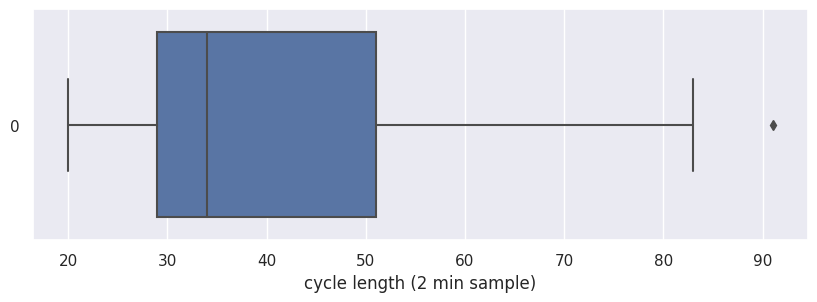

In [54]:
sns.set(font_scale=1)
plt.figure(figsize=(10,3))
sns.boxplot([leng for leng in np.array(lengths)[np.where(labels==2)[0].tolist()]], orient="h")
plt.xlabel('cycle length (2 min sample)')
plt.savefig('figures/boxplot_lengths.svg', format='svg', bbox_inches = 'tight')

sns.set(font_scale=1.5)


In [48]:
np.argmax(lengths)

125

In [ ]:
sns.set(font_scale=0.5)
plt.figure(figsize=(20, 4))
ax = sns.barplot(y=-np.array(lengths), x=np.arange(len(lengths)), palette='cividis')
plt.yticks(-np.arange(0, np.max(lengths)+1, 20), np.arange(0, np.max(lengths)+1, 20))
plt.xticks([])
plt.ylabel('cycle length', size=10)
for patch in ax.patches:
    clr = patch.get_facecolor()
    patch.set_edgecolor(clr)
plt.title('[c0, c1, ..., cn] each one with 37 columns', size=10)
plt.show()